In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import os
from skimage import io
import tqdm
from panoptes_client import Subject, Workflow
from dateutil.parser import parse
import subprocess
from IPython.display import Image, display
%matplotlib inline

Load in the reducer data and parse the columns

In [2]:
data = ascii.read('reductions/question_reducer_jet_or_not.csv', format='csv')

# change the columns to make it easier to work with
data.rename_column('data.no-there-are-no-jets-in-this-image-sequence', 'data.no')
data.rename_column('data.yes-there-is-at-least-one-jet-in-this-image-sequence', 'data.yes')

# fill in missing data
data['data.yes'].fill_value = 0
data['data.no'].fill_value = 0
data = data.filled()

In [3]:
print(f"Number of subjects: {len(data)}")

Number of subjects: 6858


First, we need to calculate the aggregated value, which we define as the one have the maximum votes for a given subject. Edge cases (50% yes, 50% no) are not handled here. We'll also calculate how many classifications each subject received. 

In [4]:
num_votes = np.asarray(data['data.no']) + np.asarray(data['data.yes'])
counts    = np.asarray(np.dstack([data['data.yes'], data['data.no']])[0])
most_likely  = np.argmax(counts, axis=1)

value_yes = most_likely==0
value_no  = most_likely==1

agreement = np.zeros_like(num_votes)

agreement[value_yes] = counts[value_yes,0]/(num_votes[value_yes])
agreement[value_no]  = counts[value_no,1]/(num_votes[value_no])

agreement = np.asarray(agreement)

In [5]:
print(agreement.min(), agreement.max(), agreement.mean())

0.5 1.0 0.8163839271590122


Looks like we have a good agreement fraction. The mean agreement is greater than 85%, so that means most subjects were handled easily. Let's check statistics on vote count:

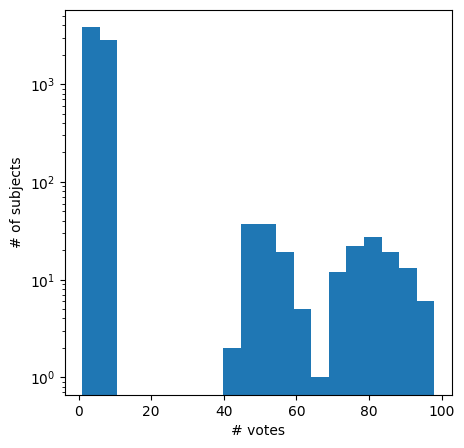

In [6]:
plt.style.use('default')

fig, axs = plt.subplots(1,1, figsize=(5,5), sharey=True)

# axs[0].hist(agreement*100, 20, range=(0,100))
# axs[0].set_xlabel('Agreement [%]')

axs.hist(num_votes, 20)
axs.set_xlabel('# votes')

axs.set_yscale('log')
# axs[1].set_yscale('log')

# axs[0].set_xlim((0, 100))

axs.set_ylabel("# of subjects")

plt.show()

The multi-modality of the distribution is from subjects that have been retired but have seen more classifications, since they get served when the project runs out of subjects. Let's print some statistics on the subject confidence:

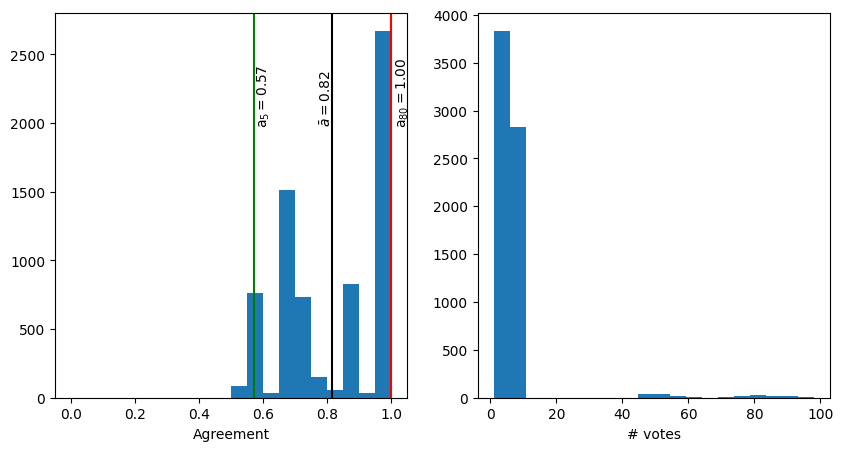

In [7]:
plt.style.use('default')

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].hist(agreement, 20, range=(0, 1))

# show the mean confidence in black
axs[0].axvline(np.mean(agreement), color='k', linestyle='solid')
axs[0].text(np.mean(agreement)*0.95, 2000, fr'$\bara={np.mean(agreement):.2f}$', rotation=90)

# show the 80th percentile in red
axs[0].axvline(np.percentile(agreement, 80), color='r', linestyle='solid')
axs[0].text(np.percentile(agreement, 80)*1.01, 2000, fr'a$_{{80}}={np.percentile(agreement, 80):.2f}$', rotation=90)

# and the 5th percentile in green
axs[0].axvline(np.percentile(agreement, 5), color='g', linestyle='solid')
axs[0].text(np.percentile(agreement, 5)*1.01, 2000, fr'a$_{{5}}={np.percentile(agreement, 5):.2f}$', rotation=90)

axs[0].set_xlabel('Agreement')

axs[1].hist(num_votes, 20)
axs[1].set_xlabel('# votes')

plt.show()

In [8]:
print(f"% of subjects above 60%: {np.sum(agreement>0.6)/len(agreement)*100:.2f}")
print(f"% of subjects above 80%: {np.sum(agreement>0.8)/len(agreement)*100:.2f}")
print(f"% of subjects above 95%: {np.sum(agreement>0.95)/len(agreement)*100:.2f}")

% of subjects above 60%: 87.69
% of subjects above 80%: 51.95
% of subjects above 95%: 38.93


Now let's look at specifically those that have jets in them (i.e. "yes" got more votes than "no").
First let's look at low agreement score data:

In [10]:
agreement_jet_mask = (agreement>0.5)&(most_likely==0)

subjects_jet  = data['subject_id'][agreement_jet_mask]
agreement_jet = agreement[agreement_jet_mask]
count_jet     = num_votes[agreement_jet_mask]
value_jet     = most_likely[agreement_jet_mask]

In [11]:
print(f"Found {len(subjects_jet)} subjects with jets")

Found 2145 subjects with jets


<Subject 70444735>


100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [00:10<00:00,  1.48it/s]


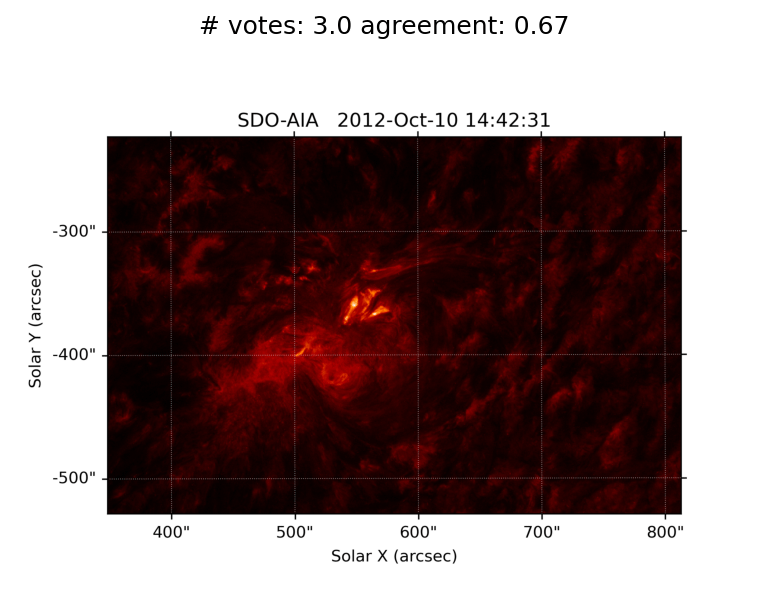

In [12]:
ind = np.random.randint(0, len(subjects_jet))

if not os.path.exists('subjects_jet'):
    os.mkdir('subjects_jet')

subjecti = subjects_jet[ind]
subject = Subject(subjecti)
print(subject)
locations = subject.raw['locations']

# ignore this if the subject was not added to the new set
if '100128' in subject.raw['links']['subject_sets']:
    for j, locationi in enumerate(tqdm.tqdm(locations)):
        try:
            location = locationi['image/png']
        except KeyError:
            location = locationi['image/jpeg']
        except Exception as e:
            raise e
        img = io.imread(location)

        fig, axi = plt.subplots(1,1, dpi=150)

        axi.imshow(img)
        axi.axis('off')

        if not os.path.exists(f'subjects_jet/{subjecti}/'):
            os.mkdir(f'subjects_jet/{subjecti}/')

        axi.set_title(f'# votes: {count_jet[ind]} agreement: {agreement_jet[ind]:.2f}' )

        plt.savefig(f'subjects_jet/{subjecti}/frame_{j:03d}.png', facecolor='white', bbox_inches='tight')
        plt.close(fig)

    out = subprocess.run(f'ffmpeg -hide_banner -loglevel error -y -r 5 -i subjects_jet/{subjecti}/frame_%03d.png -vf "split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" subjects_jet/{subjecti}.gif', shell=True)

    with open(f'subjects_jet/{subjecti}.gif','rb') as f:
        i = Image(data=f.read(), format='gif')
        display(i)

Let's repeat this for the highest confidence jets

In [13]:
agreement80_jet_mask = (agreement>0.8)&(most_likely==0)

subjects80  = data['subject_id'][agreement80_jet_mask]
agreement80 = agreement[agreement80_jet_mask]
count80     = num_votes[agreement80_jet_mask]
value80     = most_likely[agreement80_jet_mask]

print(len(subjects80))

940


In [ ]:
ind = np.random.randint(0, len(subjects80))

if not os.path.exists('subjects_jet'):
    os.mkdir('subjects_jet')

subjecti = subjects80[ind]
subject = Subject(subjecti)
print(subject)
locations = subject.raw['locations']

# ignore this if the subject was not added to the new set
if '100128' in subject.raw['links']['subject_sets']:
    for j, locationi in enumerate(tqdm.tqdm(locations)):
        try:
            location = locationi['image/png']
        except KeyError:
            location = locationi['image/jpeg']
        except Exception as e:
            raise e
        img = io.imread(location)

        fig, axi = plt.subplots(1,1, dpi=150)

        axi.imshow(img)
        axi.axis('off')

        if not os.path.exists(f'subjects_jet/{subjecti}/'):
            os.mkdir(f'subjects_jet/{subjecti}/')

        axi.set_title(f'# votes: {count80[ind]} agreement: {agreement80[ind]:.2f}' )

        plt.savefig(f'subjects_jet/{subjecti}/frame_{j:03d}.png', facecolor='white', bbox_inches='tight')
        plt.close(fig)

    out = subprocess.run(f'ffmpeg -hide_banner -loglevel error -y -r 5 -i subjects_jet/{subjecti}/frame_%03d.png -vf "split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" subjects_jet/{subjecti}.gif', shell=True)

    with open(f'subjects_jet/{subjecti}.gif','rb') as f:
        i = Image(data=f.read(), format='gif')
        display(i)

<Subject 70444457>


 67%|███████████████████████████████████████████████████████▎                           | 10/15 [00:06<00:02,  1.71it/s]